In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import manifold
import random
from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
uploaded = files.upload()

cuisines = pd.read_csv("Cuisines.csv",header=None)
cuisines.columns = ['cuisine_key','cuisine']
recipes = pd.read_csv("recipes.csv")

# can remove cuisine information later if needed, right now it is required for 
# separating sets of cuisines

recipes_data = recipes
# recipes_data = recipes.drop("cuisine", axis=1)
# cuisines_data = recipes["cuisine"]

# removing spaces in colnames for easier working

recipe_columns = recipes_data.columns
recipe_columns = [ingredient.replace(' ','_') for ingredient in recipe_columns]
recipe_columns = [ingredient.replace('\'','') for ingredient in recipe_columns]
recipes_data.columns = recipe_columns
recipes_data.columns

Saving Cuisines.csv to Cuisines.csv
Saving recipes.csv to recipes.csv


Index(['acorn_squash', 'adobo', 'african_birdseye_chile_pepper', 'ale',
       'aleppo_pepper', 'alfalfa_sprouts', 'alfredo_sauce', 'allspice',
       'almond', 'almond_butter',
       ...
       'yeast', 'yellow_curry_paste', 'yellow_food_coloring',
       'yellow_split_pea', 'yellow_squash', 'yogurt', 'zaatar', 'zest',
       'zucchini', 'cuisine'],
      dtype='object', length=710)

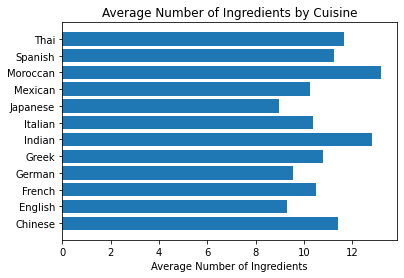

In [ ]:
num_ingredients = recipes_data.drop('cuisine',axis=1).aggregate(np.sum,axis=1)
cuisine_col = recipes_data['cuisine'].to_numpy()
num_ingredients_df = pd.DataFrame({'cuisine': cuisine_col, 'num_ingredients': num_ingredients})

avg_df = num_ingredients_df.groupby('cuisine').mean()
# avg_df
# plt.bar(np.arange(0,12,1),avg_df['num_ingredients'])
fig, ax = plt.subplots()
ax.barh(np.arange(0,12,1),avg_df['num_ingredients'])
ax.set_yticks(np.arange(0,12,1))
ax.set_yticklabels(cuisines['cuisine'])
ax.set_xlabel('Average Number of Ingredients')
ax.set_title('Average Number of Ingredients by Cuisine')
plt.savefig('/content/gdrive/MyDrive/DME/eda_avgingredients.pdf')

(8.0, 193.84615264417883, 64.75740479548661)

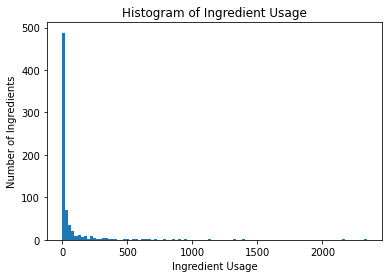

In [ ]:
# recipes_data.groupby('cuisine').sum()

recipes_melted = recipes_data.melt(id_vars=['cuisine'],value_vars=recipe_columns[:-1])
recipes_melted = recipes_melted[recipes_melted['value']>0]

ingredients_usage = recipes_melted.drop('cuisine',axis=1).groupby('variable').sum()
# ingredients_usage.sort_values('value',ascending=False).head(10)
fig, ax = plt.subplots()
ax.hist(ingredients_usage['value'], bins=100)
ax.set_xlabel('Ingredient Usage')
ax.set_ylabel('Number of Ingredients')
ax.set_title("Histogram of Ingredient Usage")

plt.savefig('/content/gdrive/MyDrive/DME/hist_ingredient_usage.pdf')
ingredients_usage.median(axis=0)['value'],ingredients_usage.std(axis=0)['value'],ingredients_usage.mean(axis=0)['value']

#Jaccard distance

Intersection: number of ingredients that are common

Union: collective ingredients used

Jaccard similarity (Intersection / Union): proportion of similar ingredients

This is the similarity between two vectors. For sets, we can consider the average of the Jaccard similarity within the set. Else, it is difficult to compare similarity directly between sets without using set members. we use jaccard distance since our binary variables are asymmetric, since '1' for an ingredient (ingredient used) has more value than 0. 

Jaccard distance: (1 - Jaccard similarity)

We could use the raw ingredients themselves in one way - using all the ingredients that are used in a cuisine at least n times (to prevent ingredients that are used only in one recipe from skewing results). This will be explored later.


In [ ]:
# jaccard similarity
def jaccard_binary(x,y):
    """A function for finding the similarity between two binary vectors"""
    intersection = np.logical_and(x, y)
    union = np.logical_or(x, y)
    similarity = intersection.sum() / float(union.sum())
    return similarity

In [ ]:
# 

mean_jaccard_dist = dict()
jaccard_dist = np.array([])

for cuisine_val in pd.unique(recipes_data.cuisine):
  filtered = recipes_data[recipes_data['cuisine']==cuisine_val]

# dropping cuisine column before calculating jaccard distance
  filtered.drop("cuisine", axis=1)
  for _, row_x in filtered.iterrows():
    for _,row_y in filtered.iterrows():
      j_dist = jaccard_binary(row_x, row_y)
      jaccard_dist = np.append(jaccard_dist, j_dist)

  mean_cuisine_recipes_similarity = jaccard_dist.mean()
  mean_jaccard_dist[cuisine_val] = mean_cuisine_recipes_similarity


KeyboardInterrupt: ignored

In [ ]:
mean_jaccard_dist

Recipes within each cuisine are not that similar to each other. This shows that there is a wide variety of ingredients that are used in each cuisine. An analysis of the most common ingredients by cuisine will help understand this better. 

For within cuisine similarity, we identify the most representative recipe for
a cuisine, and calculate similarity between the representatives. For this, we
will need to perform clustering on this dataset

In [ ]:
# MDS - need a dissimalirity matrix first. We use Jaccard distance for this
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS

filtered = recipes_data.drop("cuisine", axis=1).to_numpy()
dissimilarity_jaccard = pairwise_distances(filtered, metric="jaccard")# generating lower dimensional embedding using metric MDS

embedding_j = MDS(n_components=2, dissimilarity='precomputed', random_state=12324)
jaccard_embedding = embedding_j.fit_transform(dissimilarity_jaccard)
jaccard_embedding.shape

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1738: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


(4236, 2)

In [ ]:
cuisines.head(15)

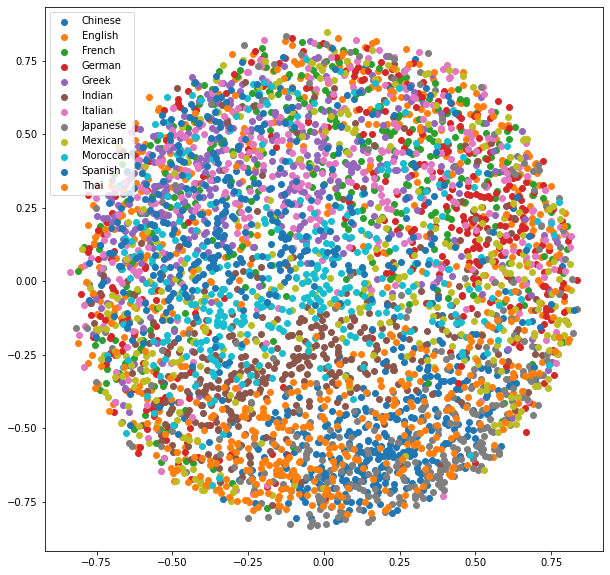

In [ ]:
# visualization
recipes_y = pd.DataFrame(recipes.cuisine)
lower_x = pd.DataFrame(jaccard_embedding)

mds_data = pd.concat([lower_x, recipes_y], axis=1)

fig = plt.figure(figsize=(10,10))
for cuisine_val in range(0,12):
  plt.scatter(mds_data[mds_data['cuisine']==cuisine_val][[0]],
              mds_data[mds_data['cuisine']==cuisine_val][[1]])
  # ax.set_title("Cuisine: {}".format(cuisine_val))
  # ax.set_xlabel("Dim1")
  # ax.set_ylabel("Dim2")
# plt.legend(cuisines['cuisine'])
# for cuisine_val in range(0,12):
#   ax = fig.add_subplot(4, 3, cuisine_val+1)
#   ax.scatter(mds_data[mds_data['cuisine']==cuisine_val][[0]],
#               mds_data[mds_data['cuisine']==cuisine_val][[1]])
#   cuisine_name = (cuisines[cuisines['cuisine_key']==cuisine_val+1]['cuisine'].to_numpy())
#   ax.set_title("Cuisine: {}".format(cuisine_name))
#   ax.set_xlabel("Dim1")
#   ax.set_ylabel("Dim2")


# plt.savefig('/content/gdrive/MyDrive/DME/jaccard_MDS.pdf')


Findings:


1.   Chinese cooking seems to be the most uniform in terms of ingredients, since all recipes seem to be clustered together
2.   There seem to be 3 distinct groups within the cuisines: East Asian  (Chinese, Japanese and Thai), European (British, French, German, Italian, Spanish) and "Spicy" (Indian, Morroccan and Mexican). In the last group, Mexican and Morrocan seem more spread out than Indian, which has some tight grouping, but also some spread in terms of its recipes.
3. One could also place Spanish, Morroccan and Mexican cuisine in the same group, given their cultural and historical relation. This would place Indian cuisine in a separate group by itself. This makes gastronomic sense as well.



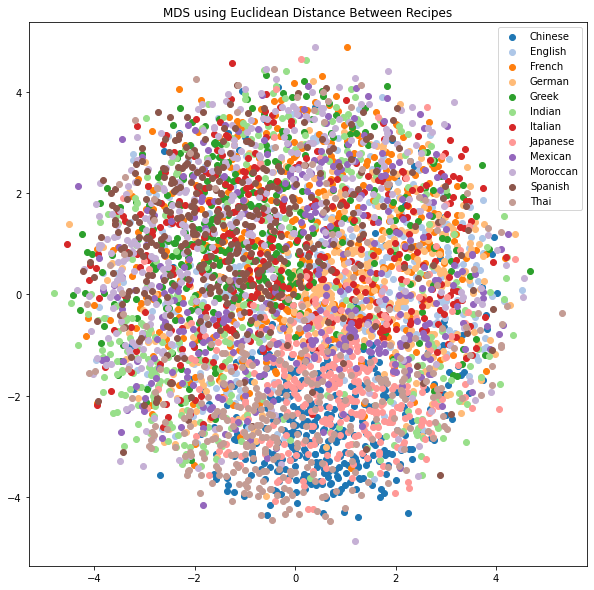

In [ ]:
# MDS - need a dissimalirity matrix first. We use Jaccard distance for this
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS

filtered = recipes_data.drop("cuisine", axis=1).to_numpy()

embedding_e = MDS(n_components=2, dissimilarity='euclidean', random_state=12324)
euclidean_embedding = embedding_e.fit_transform(filtered)
euclidean_embedding.shape

# visualization
recipes_y = pd.DataFrame(recipes.cuisine)
lower_x = pd.DataFrame(euclidean_embedding)

mds_data = pd.concat([lower_x, recipes_y], axis=1)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
    '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94',
    '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d',
    '#17becf', '#9edae5'])

for cuisine_val in range(0,12):
  ax.scatter(mds_data[mds_data['cuisine']==cuisine_val][[0]],
              mds_data[mds_data['cuisine']==cuisine_val][[1]])
  ax.set_title("MDS using Euclidean Distance Between Recipes")
  # ax.set_xlabel("Dim1")
  # ax.set_ylabel("Dim2")
plt.legend(cuisines['cuisine'])
# for cuisine_val in range(0,12):
#   ax = fig.add_subplot(4, 3, cuisine_val+1)
#   ax.scatter(mds_data[mds_data['cuisine']==cuisine_val][[0]],
#               mds_data[mds_data['cuisine']==cuisine_val][[1]])
#   cuisine_name = (cuisines[cuisines['cuisine_key']==cuisine_val+1]['cuisine'].to_numpy())
  # ax.set_title("Cuisine: {}".format(cuisine_name))
#   ax.set_xlabel("Dim1")
#   ax.set_ylabel("Dim2")


plt.savefig('/content/gdrive/MyDrive/DME/euclidean_MDS.pdf')


# Cosine Similarity
Here we calculate the cosine similarity between each recipe. Each recipe is treated as an #ingredient-dimensional vector, with possible coordinates of 0 or 1 for each dimension. The cosine of the distance between two such vectors gives the relative closeness.

In [ ]:
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS

filtered = recipes_data.drop("cuisine", axis=1).to_numpy()
dissimilarity_cosine = pairwise_distances(filtered, metric="cosine")

embedding_c = MDS(n_components=2, dissimilarity='precomputed', random_state=12324)
cosine_embedding = embedding_c.fit_transform(dissimilarity_cosine)
cosine_embedding.shape

(4236, 2)

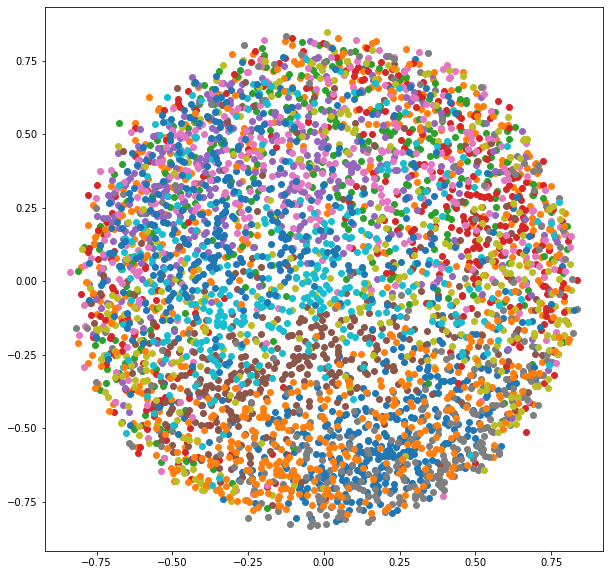

<Figure size 1440x1440 with 0 Axes>

In [ ]:
# visualization
recipes_y = pd.DataFrame(recipes.cuisine)
cosine_embedding_x = pd.DataFrame(cosine_embedding)

cosine_mds_data = pd.concat([cosine_embedding_x, recipes_y], axis=1)

fig = plt.figure(figsize=(10,10))
for cuisine_val in range(0,12):
  plt.scatter(mds_data[mds_data['cuisine']==cuisine_val][[0]],
              mds_data[mds_data['cuisine']==cuisine_val][[1]])

fig = plt.figure(figsize=(20,20))
# for cuisine_val in range(0,12):
#   ax = fig.add_subplot(4, 3, cuisine_val+1)
#   ax.scatter(cosine_mds_data[cosine_mds_data['cuisine']==cuisine_val][[0]],
#               cosine_mds_data[cosine_mds_data['cuisine']==cuisine_val][[1]])
#   cuisine_name = (cuisines[cuisines['cuisine_key']==cuisine_val+1]['cuisine'].to_numpy())
#   ax.set_title("Cuisine: {}".format(cuisine_name))
#   ax.set_xlabel("Dim1")
#   ax.set_ylabel("Dim2")


# plt.savefig('/content/gdrive/MyDrive/DME/cosine_MDS.pdf')


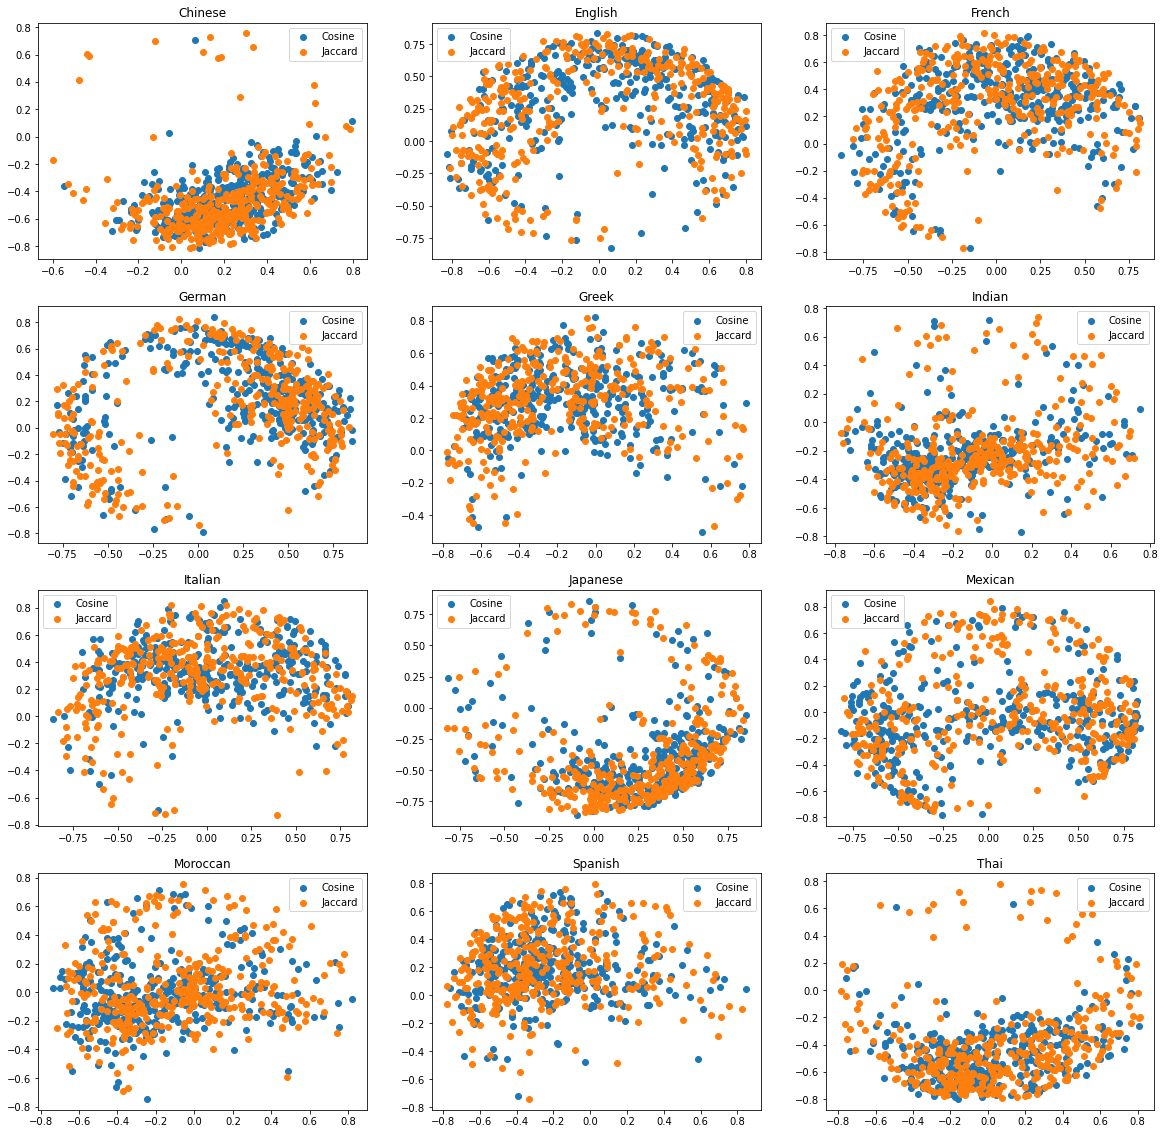

In [ ]:
# combining jaccard and cosine in one table
mds_data["DistanceMeasure"] = "Jaccard"
cosine_mds_data["DistanceMeasure"] = "Cosine"

all_mds_df = pd.concat([mds_data, cosine_mds_data], axis=0)

fig = plt.figure(figsize=(20,20))

for cuisine_val in range(0,12):
  mds_df = all_mds_df[all_mds_df['cuisine']==cuisine_val]
  groups = mds_df.groupby('DistanceMeasure')
  ax = fig.add_subplot(4, 3, cuisine_val+1)
  cuisine_name = (cuisines[cuisines['cuisine_key']==cuisine_val+1]['cuisine'].to_numpy())
  for name, group in groups:
    ax.scatter(group[[0]], group[[1]], marker='o', label=name)
    ax.set_title(cuisine_name[0])
    ax.legend()

plt.savefig('/content/gdrive/MyDrive/DME/MDS_JaccardCosine.pdf')


# TF-IDF Similarity
Term frequency - inverse document frequency is a method from information retrieval, that is used to rank the importance of documents with respect to a particular query. The concept can be extended to our case, by considering each cuisine as a document, and each ingredient in a recipe as a term in the document. When working with documents, this enables weighing by inverse frequency - the more frequently a term appears in a document the less relevant it might actually be (simple examples are articles, prepositions, conjunctions etc.). In our case, this might give lesser importance to ingredients like salt, sugar etc. which are extremely common, and allow more specific ingredients for the cuisine to get more importance.

In [ ]:
# first we add the collated ingredient list as a column to the dataframe

ingredients_only = recipes_data.drop('cuisine',axis=1)
ingredient_cols = (ingredients_only.columns).to_numpy()
ingredient_cols = [i for i in ingredient_cols]
ingredient_cols
ingredients_only.head()
ingredient_list = []

for _, row in ingredients_only.iterrows():
  row = row.to_numpy()
  row_doc = [ingredient for ingredient in ingredient_cols
             if row[ingredient_cols.index(ingredient)]==1]
  row_doc = list(row_doc)
  ingredient_list.append(row_doc)

recipes_data['ingredient_list'] = ingredient_list


In [ ]:
recipes_data.ingredient_list

In [ ]:
# create (cuisine - collated ingredient list) table - this will be the main 
# dataset for calculating TF-IDF scores for each ingredient

# cuisine_ingredient_doc = dict()

# for cuisine_val in range(0,12):
#   ingredients_only = recipes_data[recipes_data['cuisine']==cuisine_val]\
#     ['ingredient_list'].to_numpy()

#   all_cuisine_ingredients = [ingredient for ingredient_list in ingredients_only for 
#                     ingredient in ingredient_list]

#   cuisine_ingredient_doc[cuisine_val] = all_cuisine_ingredients
cuisine_ingredient_doc = dict()

for cuisine_val in range(0,12):
  ingredients_only = recipes_data[recipes_data['cuisine']==cuisine_val]\
    ['ingredient_list'].to_numpy()

  all_cuisine_ingredients = [ingredient_list for ingredient_list in ingredients_only]

  cuisine_ingredient_doc[cuisine_val] = all_cuisine_ingredients



In [ ]:
# calculate TF
# ingredient_cols - list of all ingredients
# cuisine_ingredient_doc - dict of cuisines (key) and list of ingredients (value)

def calculate_TF(term, document):
  all_cuisine_ingredients = [ingredient for ingredient_list in document for 
                    ingredient in ingredient_list]
  return all_cuisine_ingredients.count(term)/float(len(document))



In [ ]:
# calculate IDF
import math
def inverseDocumentFrequency(term, all_cuisines):
  num_docs = 0
  for i in range(0,12):
    all_ingredients = all_cuisines[i]
    all_cuisine_ingredients = [ingredient for ingredient_list in all_ingredients for 
                      ingredient in ingredient_list]
    if term in all_cuisine_ingredients:
      num_docs+=1
  
  if num_docs>0:
    return 1.0 + math.log(float(len(all_cuisines)/num_docs))
  
  elif num_docs==0:
    return 1.0


In [ ]:
# for each ingredient, calculate TF-IDF score for all cuisines

tf = [[calculate_TF(ingredient, cuisine) for ingredient in ingredient_cols] for cuisine in cuisine_ingredient_doc.values()]

idf = np.array([inverseDocumentFrequency(ingredient, cuisine_ingredient_doc) for ingredient in ingredient_cols])


In [ ]:
cuisine_tfidf = pd.DataFrame()


for i in range(0,12):
  tf_cuisine = np.array(tf[i])
  tfidf = tf_cuisine*idf
  cuisine_col = np.ones(len(ingredient_cols),dtype=np.int8)*i
  tfidf_df = pd.DataFrame({'Ingredient':ingredient_cols,
                           'tf': tf_cuisine,
                           'idf':idf, 
                          'tfidf_score': tfidf,
                          'cuisine': cuisine_col})
  
  cuisine_tfidf = pd.concat([cuisine_tfidf, tfidf_df],axis=0)

cuisine_tfidf.to_csv('/content/gdrive/MyDrive/DME/cuisine_tfidf.csv')


In [ ]:
# cuisine_tfidf[((cuisine_tfidf['cuisine']==3)) & np.logical_not(cuisine_tfidf['Ingredient'].isin(['salt','pepper','water','lemon_juice','sugar']))].sort_values('tfidf_score',axis=0,ascending=False).head(10)#

# cuisine_tfidf[np.logical_not(cuisine_tfidf['Ingredient'].isin(['salt','pepper','water','lemon_juice','sugar']))]


imp_ingred = pd.DataFrame()

for i in range(12):
# 10 most important ingredients for each cuisine
    imp_ingred = pd.concat([imp_ingred, cuisine_tfidf[((cuisine_tfidf['cuisine']==i)) & np.logical_not(cuisine_tfidf['Ingredient'].isin(['salt','pepper','water','lemon_juice','sugar','lime']))].sort_values('tfidf_score',axis=0,ascending=False).head(5)#
])

imp_ingred.to_csv('/content/gdrive/MyDrive/DME/imp_ingred5.csv')

In [ ]:
# 10 most important ingredients for each cuisine that are not used in all cuisines
cuisine_tfidf[(cuisine_tfidf['cuisine']==11) & (cuisine_tfidf['idf']!=1.0)]\
  .sort_values('tfidf_score',axis=0,ascending=False).head(10)

,Ingredient,tf,idf,tfidf_score,cuisine
245,fish_sauce,0.507082,2.386294,1.210047,11
166,coconut_milk_or_cream,0.405099,1.875469,0.759751,11
204,curry_paste,0.252125,2.791759,0.703871,11
361,lime,0.390935,1.287682,0.503400,11
269,ginger,0.385269,1.087011,0.418792,11
586,soy_sauce,0.368272,1.087011,0.400316,11
158,cilantro,0.359773,1.087011,0.391078,11
449,peanut,0.161473,2.098612,0.338869,11
450,peanut_butter,0.172805,1.875469,0.324089,11
338,kaffir_lime,0.087819,3.484907,0.306040,11


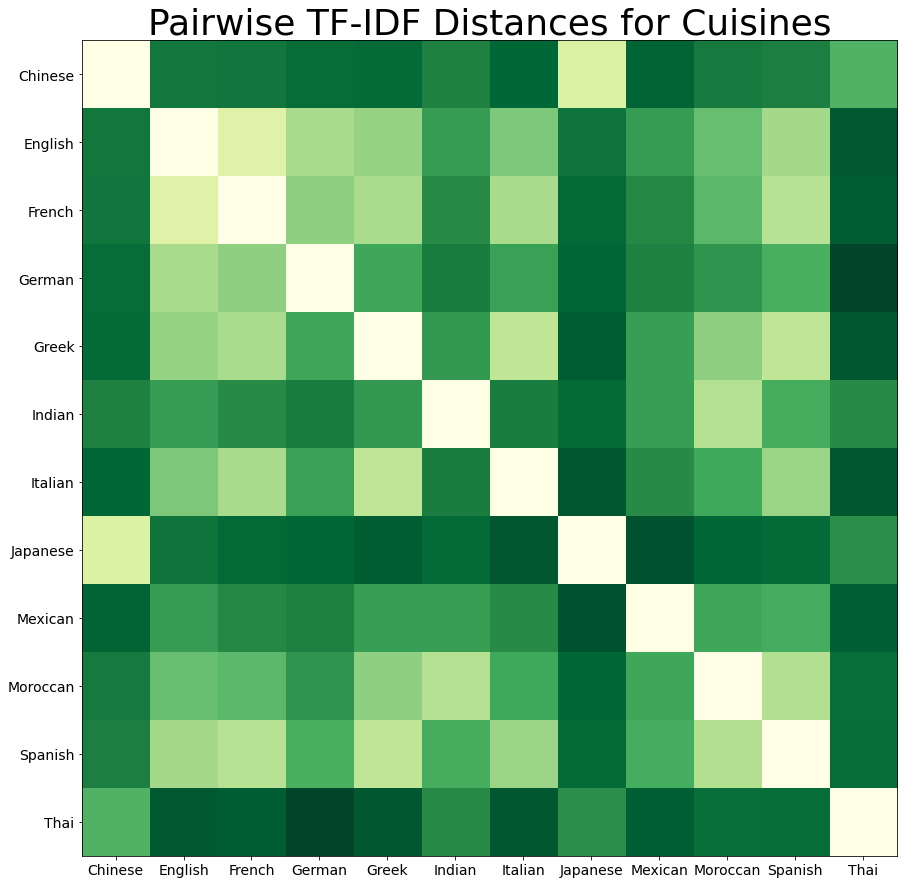

In [ ]:
# reshape tf-idf table to cuisines x ingredients
# this will help calculate inter-cuisine distance based on tf-idf scores
cuisine_tfidf_np = cuisine_tfidf.to_numpy()

tfidf_scores = cuisine_tfidf_np[:,3]
tfidf_scores = tfidf_scores.reshape(12,-1)

from sklearn.metrics import pairwise_distances
import seaborn as sns

tfidf_distances = pairwise_distances(tfidf_scores, metric="cosine")
tfidf_distances_df = pd.DataFrame(tfidf_distances, index=cuisines['cuisine'], columns=cuisines['cuisine'])

plt.figure(figsize=(15,15)) 
plt.imshow(tfidf_distances_df, cmap='YlGn')
# plt.colorbar()
plt.xticks(range(len(tfidf_distances_df)),tfidf_distances_df.index, fontsize=14)
plt.yticks(range(len(tfidf_distances_df)),tfidf_distances_df.columns, fontsize=14)
plt.title("Pairwise TF-IDF Distances for Cuisines",fontsize=36)
plt.savefig('/content/gdrive/MyDrive/DME/cuisine_similarity_tfidf.pdf')
plt.show()



In [ ]:
# top most important ingredients overall
cuisine_tfidf[cuisine_tfidf['Ingredient'].isin([i for i in cuisine_tfidf['Ingredient'] if 'sauce' in i])]\
  .sort_values('tfidf_score',axis=0,ascending=False).head(30)

,Ingredient,tf,idf,tfidf_score,cuisine
245,fish_sauce,0.507082,2.386294,1.210047,11
586,soy_sauce,0.844193,1.087011,0.917647,0
586,soy_sauce,0.705382,1.087011,0.766759,7
586,soy_sauce,0.368272,1.087011,0.400316,11
226,enchilada_sauce,0.124646,2.791759,0.347981,8
315,hoisin_sauce,0.130312,2.098612,0.273474,0
430,oyster_sauce,0.099150,2.386294,0.236601,0
445,pasta_sauce,0.116147,1.875469,0.217831,6
430,oyster_sauce,0.065156,2.386294,0.155481,11
644,tomato_sauce,0.135977,1.000000,0.135977,6


In [ ]:
np.where(('oil' in cuisine_tfidf['Ingredient']))

cuisine_tfidf['Ingredient'].isin([i for i in cuisine_tfidf['Ingredient'] if 'sauce' in i])
len([i for i in range(1,len(tf_cuisine)+1)])

cuisine_tfidf[cuisine_tfidf['Ingredient'].isin([i for i in cuisine_tfidf['Ingredient'] if 'oil' in i])].groupby('cuisine').mean()


,tf,idf,tfidf_score
cuisine,,,
0,0.068555,2.286753,0.096001
1,0.032106,2.286753,0.033662
2,0.037583,2.286753,0.038304
3,0.025496,2.286753,0.026306
4,0.048347,2.286753,0.048364
5,0.040982,2.286753,0.043819
6,0.035883,2.286753,0.035883
7,0.039282,2.286753,0.053333
8,0.023418,2.286753,0.023615


In [ ]:
cuisine_tfidf[cuisine_tfidf['Ingredient'].isin([i for i in cuisine_tfidf['Ingredient'] if 'sauce' in i])].groupby('cuisine').mean()


,tf,idf,tfidf_score
cuisine,,,
0,0.050992,2.359902,0.068572
1,0.007318,2.359902,0.009152
2,0.002597,2.359902,0.002793
3,0.002597,2.359902,0.003467
4,0.004367,2.359902,0.005157
5,0.004603,2.359902,0.005149
6,0.012866,2.359902,0.020508
7,0.036945,2.359902,0.045014
8,0.014282,2.359902,0.026364


In [ ]:
# 10 most important ingredients for each cuisine that are not used in all cuisines
cuisine_tfidf[(cuisine_tfidf['cuisine']==11) & (cuisine_tfidf['idf']!=1.0)]\
  .sort_values('tfidf_score',axis=0,ascending=False).head(10)

NameError: ignored

In [ ]:
filtered = recipes_data.drop("cuisine", axis=1).to_numpy()


# PCA

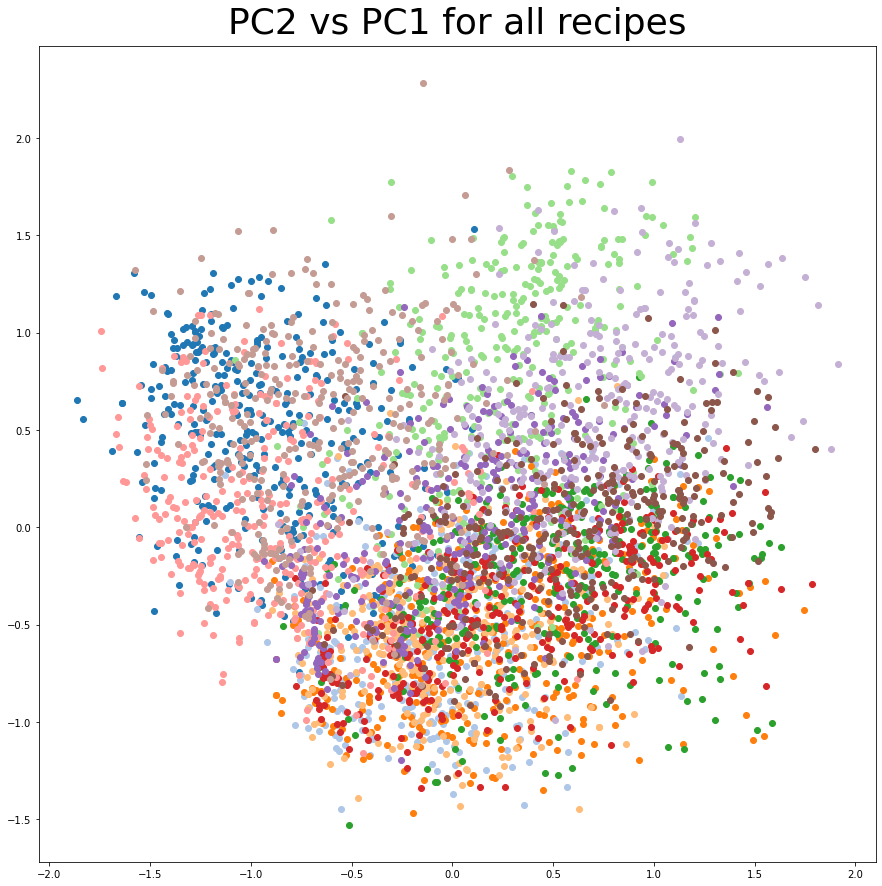

In [ ]:
from sklearn.decomposition import PCA

# filtered = recipes_data.drop("cuisine", axis=1).to_numpy()
cuisine_pca = PCA(n_components=2,random_state=12345)
cuisine_princomp = cuisine_pca.fit_transform(filtered)

recipes_y = pd.DataFrame(recipes.cuisine)
pca_embedding_x = pd.DataFrame(cuisine_princomp)

pca_mds_data = pd.concat([pca_embedding_x, recipes_y], axis=1)

fig = plt.figure(figsize=(15,15))

ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
    '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94',
    '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d',
    '#17becf', '#9edae5'])

for cuisine_val in range(0,12):
  ax.scatter(pca_mds_data[pca_mds_data['cuisine']==cuisine_val][[0]],
              pca_mds_data[pca_mds_data['cuisine']==cuisine_val][[1]])
  cuisine_name = (cuisines[cuisines['cuisine_key']==cuisine_val+1]['cuisine'].to_numpy())
# ax.legend(cuisines['cuisine'], fontsize=14)
ax.set_title("PC2 vs PC1 for all recipes",fontsize=36,va='bottom')


plt.savefig('/content/gdrive/MyDrive/DME/cuisine_pca.pdf')

# for cuisine_val in range(0,12):
#   ax = fig.add_subplot(4, 3, cuisine_val+1)
#   ax.scatter(pca_mds_data[pca_mds_data['cuisine']==cuisine_val][[0]],
#               pca_mds_data[pca_mds_data['cuisine']==cuisine_val][[1]])
#   cuisine_name = (cuisines[cuisines['cuisine_key']==cuisine_val+1]['cuisine'].to_numpy())
#   ax.set_title("Cuisine: {}".format(cuisine_name))
#   ax.set_xlabel("Dim1")
#   ax.set_ylabel("Dim2")


In [ ]:
pca_components = pd.DataFrame((cuisine_pca.components_).T,columns=["PC1","PC2","PC3"])
pc1 = pca_components.sort_values(axis=0,by=['PC1'],ascending=False)
pc2 = pca_components.sort_values(axis=0,by=['PC2'],ascending=False)
pc3 = pca_components.sort_values(axis=0,by=['PC3'],ascending=False)

pc1_indices = pc1.head(10).index.to_numpy()
pc1_cols = [recipe_columns[i] for i in pc1_indices]

pc2_indices = pc2.head(10).index.to_numpy()
pc2_cols = [recipe_columns[i] for i in pc2_indices]

pc3_indices = pc3.head(10).index.to_numpy()
pc3_cols = [recipe_columns[i] for i in pc3_indices]

pc1_cols, pc2_cols, pc3_cols

(['onion',
  'olive_oil',
  'tomato',
  'garlic',
  'pepper',
  'salt',
  'parsley',
  'cumin',
  'oregano',
  'wine'],
 ['garlic',
  'ginger',
  'cumin',
  'chicken',
  'cilantro',
  'soy_sauce',
  'coriander',
  'turmeric',
  'vegetable_oil',
  'chile_pepper'],
 ['salt',
  'pepper',
  'water',
  'vegetable_oil',
  'flour',
  'onion',
  'egg',
  'beef',
  'cumin',
  'sugar'])

In [ ]:
recipe_columns[458]

'pepper'

# t-SNE

In [ ]:
from sklearn.manifold import t_sne
from sklearn.metrics import pairwise_distances

filtered = recipes_data.drop("cuisine", axis=1).to_numpy()
dissimilarity_cosine = pairwise_distances(filtered, metric="cosine")
embedding_tsne = t_sne.TSNE(n_components = 2, random_state=12345, perplexity=50, n_iter=5000)
embedded_tsne = embedding_tsne.fit_transform(cuisine_princomp)

recipes_y = pd.DataFrame(recipes.cuisine)
tsne_embedding_x = pd.DataFrame(embedded_tsne)

tsne_mds_data = pd.concat([tsne_embedding_x, recipes_y], axis=1)


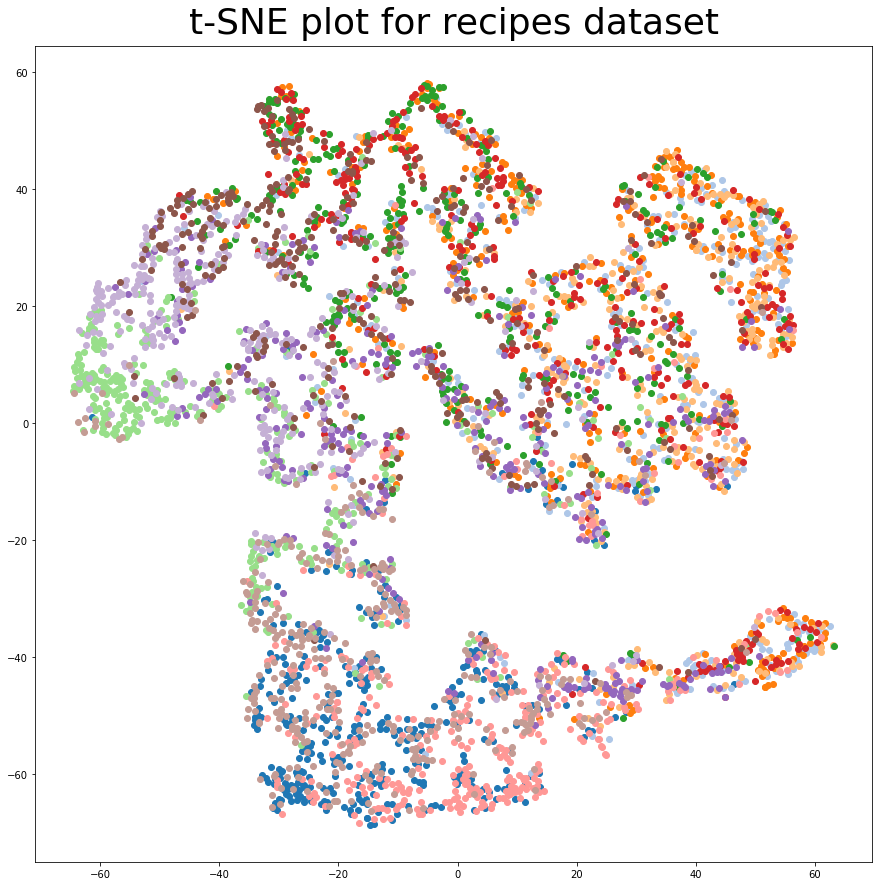

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
    '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94',
    '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d',
    '#17becf', '#9edae5'])

for cuisine_val in range(0,12):
  ax.scatter(tsne_mds_data[tsne_mds_data['cuisine']==cuisine_val][[0]],
              tsne_mds_data[tsne_mds_data['cuisine']==cuisine_val][[1]],
              cmap="coolwarm")
  cuisine_name = (cuisines[cuisines['cuisine_key']==cuisine_val+1]['cuisine'].to_numpy())
# ax.legend(cuisines['cuisine'], fontsize=14)
ax.set_title("t-SNE plot for recipes dataset",fontsize=36,va='bottom')

plt.savefig('/content/gdrive/MyDrive/DME/cuisine_tsne.pdf')


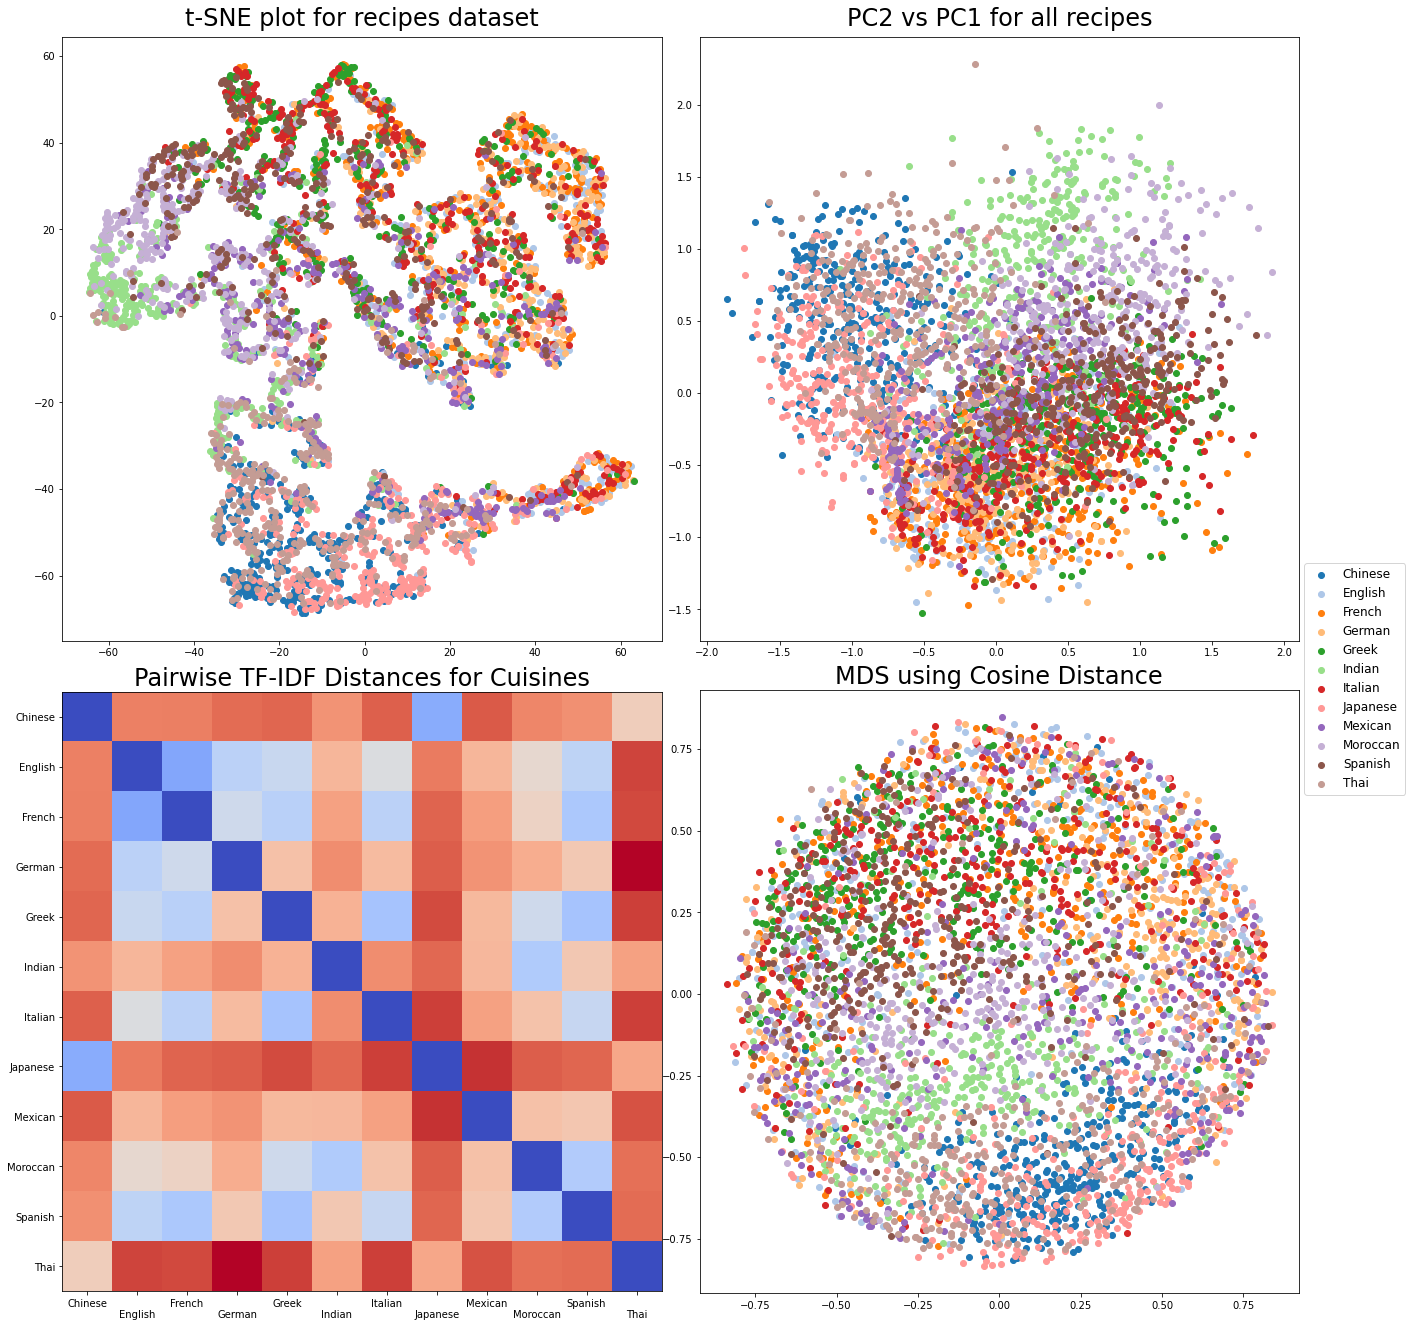

In [ ]:
fig = plt.figure(figsize=(20,20))

ax1 = fig.add_subplot(221)
ax1.set_prop_cycle(color=[
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
    '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94',
    '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d',
    '#17becf', '#9edae5'])

for cuisine_val in range(0,12):
  ax1.scatter(tsne_mds_data[tsne_mds_data['cuisine']==cuisine_val][[0]],
              tsne_mds_data[tsne_mds_data['cuisine']==cuisine_val][[1]],
              cmap="coolwarm")
  cuisine_name = (cuisines[cuisines['cuisine_key']==cuisine_val+1]['cuisine'].to_numpy())
# ax.legend(cuisines['cuisine'], fontsize=14)
ax1.set_title("t-SNE plot for recipes dataset",fontsize=24,va='bottom')
# for item in ([ax.xaxis.label, ax.yaxis.label] +
#              ax.get_xticklabels() + ax.get_yticklabels()):
#     item.set_fontsize(14)


ax2 = fig.add_subplot(222)
ax2.set_prop_cycle(color=[
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
    '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94',
    '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d',
    '#17becf', '#9edae5'])
for cuisine_val in range(0,12):
  ax2.scatter(pca_mds_data[pca_mds_data['cuisine']==cuisine_val][[0]],
              pca_mds_data[pca_mds_data['cuisine']==cuisine_val][[1]])
  cuisine_name = (cuisines[cuisines['cuisine_key']==cuisine_val+1]['cuisine'].to_numpy())
ax2.set_title("PC2 vs PC1 for all recipes",fontsize=24,va='bottom')
# for item in ([ax.xaxis.label, ax.yaxis.label] +
#              ax.get_xticklabels() + ax.get_yticklabels()):
#     item.set_fontsize(14)

# ax.legend(cuisines['cuisine'],loc=7,bbox_to_anchor=(1.1,0.52), fontsize=16)


ax3 = fig.add_subplot(223)
ax3.set_prop_cycle(color=[
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
    '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94',
    '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d',
    '#17becf', '#9edae5'])
ax3.imshow(tfidf_distances_df, cmap='coolwarm')
# plt.colorbar()
ax3.set_xticks(range(len(tfidf_distances_df)))
ax3.set_xticklabels(["\n"*(i%2) + l for i,l in enumerate(tfidf_distances_df.index)])
ax3.set_yticks(range(len(tfidf_distances_df)))
ax3.set_yticklabels(tfidf_distances_df.columns)
ax3.set_title("Pairwise TF-IDF Distances for Cuisines",fontsize=24)
for item in ([ax3.xaxis.label, ax3.yaxis.label] +
             ax3.get_xticklabels() + ax3.get_yticklabels()):
    item.set_fontsize(10)


recipes_y = pd.DataFrame(recipes.cuisine)
cosine_embedding_x = pd.DataFrame(cosine_embedding)

cosine_mds_data = pd.concat([cosine_embedding_x, recipes_y], axis=1)

ax4 = fig.add_subplot(224)
ax4.set_prop_cycle(color=[
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
    '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94',
    '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d',
    '#17becf', '#9edae5'])
for cuisine_val in range(0,12):
  ax4.scatter(mds_data[mds_data['cuisine']==cuisine_val][[0]],
              mds_data[mds_data['cuisine']==cuisine_val][[1]])
ax4.set_title("MDS using Cosine Distance",fontsize=24)
# for item in ([ax.xaxis.label, ax.yaxis.label] +
#              ax.get_xticklabels() + ax.get_yticklabels()):
#     item.set_fontsize(14)

fig.tight_layout()
# plt.subplots_adjust(right=0.9,left=0.125,top=0.9,bottom=0.1,wspace=0.2,hspace=0.2)
plt.subplots_adjust(right=0.9,top=0.9)
fig.legend(cuisines['cuisine'],loc=7,bbox_to_anchor=(0.98,0.45), fontsize=12)


plt.savefig('/content/gdrive/MyDrive/DME/all_plots2.pdf')




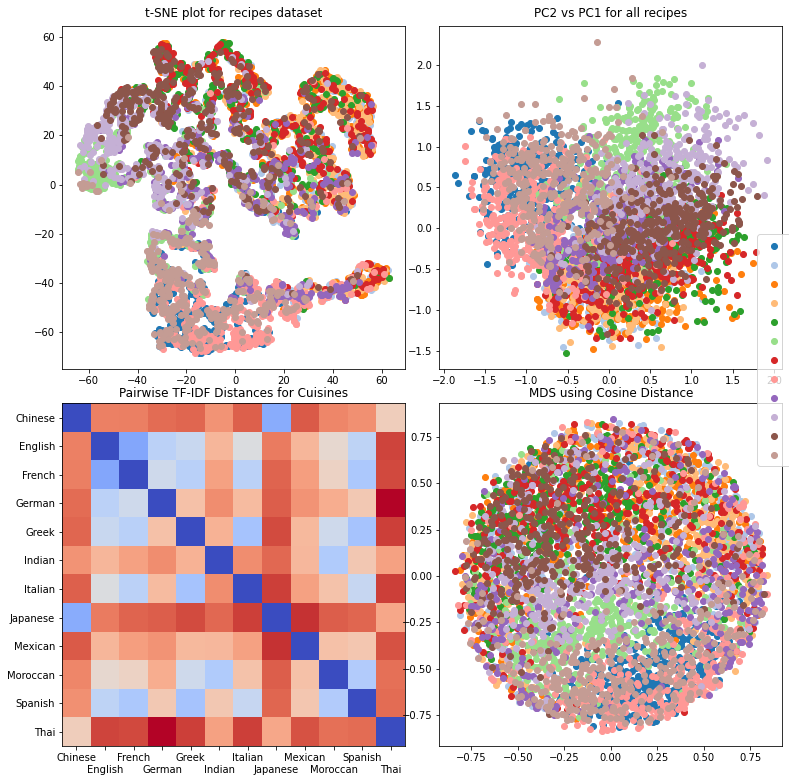

In [ ]:
from matplotlib import gridspec

fig = plt.figure(figsize=(15,15))
nrow = 2
ncol = 2

# fig = plt.figure(figsize=(ncol+1, nrow+1)) 

gs = gridspec.GridSpec(nrow, ncol,
         wspace=0.1, hspace=0.1, 
         top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), 
         left=0.5/(ncol+1), right=1-0.5/(ncol+1))
# gs = gridspec.GridSpec(nrow, ncol, width_ratios=[1, 1],
#          wspace=0.0, hspace=0.1, top=0.65, bottom=0.05, left=0.2, right=0.845) 


ax1 = fig.add_subplot(gs[0,0])
ax1.set_prop_cycle(color=[
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
    '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94',
    '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d',
    '#17becf', '#9edae5'])

for cuisine_val in range(0,12):
  ax1.scatter(tsne_mds_data[tsne_mds_data['cuisine']==cuisine_val][[0]],
              tsne_mds_data[tsne_mds_data['cuisine']==cuisine_val][[1]],
              cmap="coolwarm")
  cuisine_name = (cuisines[cuisines['cuisine_key']==cuisine_val+1]['cuisine'].to_numpy())
# ax.legend(cuisines['cuisine'], fontsize=14)
ax1.set_title("t-SNE plot for recipes dataset",fontsize=12,va='bottom')
# for item in ([ax.xaxis.label, ax.yaxis.label] +
#              ax.get_xticklabels() + ax.get_yticklabels()):
#     item.set_fontsize(14)


ax2 = fig.add_subplot(gs[0,1])
ax2.set_prop_cycle(color=[
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
    '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94',
    '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d',
    '#17becf', '#9edae5'])
for cuisine_val in range(0,12):
  ax2.scatter(pca_mds_data[pca_mds_data['cuisine']==cuisine_val][[0]],
              pca_mds_data[pca_mds_data['cuisine']==cuisine_val][[1]])
  cuisine_name = (cuisines[cuisines['cuisine_key']==cuisine_val+1]['cuisine'].to_numpy())
ax2.set_title("PC2 vs PC1 for all recipes",fontsize=12,va='bottom')
# for item in ([ax.xaxis.label, ax.yaxis.label] +
#              ax.get_xticklabels() + ax.get_yticklabels()):
#     item.set_fontsize(14)

# ax.legend(cuisines['cuisine'],loc=7,bbox_to_anchor=(1.1,0.52), fontsize=16)


ax3 = fig.add_subplot(gs[1,0])
ax3.set_prop_cycle(color=[
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
    '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94',
    '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d',
    '#17becf', '#9edae5'])
ax3.imshow(tfidf_distances_df, cmap='coolwarm')
# plt.colorbar()
ax3.set_xticks(range(len(tfidf_distances_df)))
ax3.set_xticklabels(["\n"*(i%2) + l for i,l in enumerate(tfidf_distances_df.index)])
ax3.set_yticks(range(len(tfidf_distances_df)))
ax3.set_yticklabels(tfidf_distances_df.columns)
ax3.set_title("Pairwise TF-IDF Distances for Cuisines",fontsize=12)
for item in ([ax3.xaxis.label, ax3.yaxis.label] +
             ax3.get_xticklabels() + ax3.get_yticklabels()):
    item.set_fontsize(10)


recipes_y = pd.DataFrame(recipes.cuisine)
cosine_embedding_x = pd.DataFrame(cosine_embedding)

cosine_mds_data = pd.concat([cosine_embedding_x, recipes_y], axis=1)

ax4 = fig.add_subplot(gs[1,1])
ax4.set_prop_cycle(color=[
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
    '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94',
    '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d',
    '#17becf', '#9edae5'])
for cuisine_val in range(0,12):
  ax4.scatter(mds_data[mds_data['cuisine']==cuisine_val][[0]],
              mds_data[mds_data['cuisine']==cuisine_val][[1]])
ax4.set_title("MDS using Cosine Distance",fontsize=12)
# for item in ([ax.xaxis.label, ax.yaxis.label] +
#              ax.get_xticklabels() + ax.get_yticklabels()):
#     item.set_fontsize(14)

# fig.tight_layout()
# plt.subplots_adjust(right=0.9,left=0.125,top=0.9,bottom=0.1,wspace=0.2,hspace=0.2)
plt.subplots_adjust(right=0.9,top=0.9)
fig.legend(cuisines['cuisine'],loc=7,bbox_to_anchor=(0.8,0.4), fontsize=12)
# fig.legend(cuisines['cuisine'])

# plt.savefig('/content/gdrive/MyDrive/DME/all_plots.pdf')


